### Проект: вариант 2
#### Задание 1. A/B-тестирование
#### 1.1 Условие
Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

#### 1.2 Входные данные
`groups_data` - срез данных с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А - контрольная группа, В - целевая группа).

`groups_add_data` - дополнительный срез информации о принадлежности пользователя к контрольной или экспериментальной группе.

`active_studs_data` - информация о пользователях, которые зашли на платформу в дни проведения эксперимента.

`checks_data` - информация об оплатах пользователей в дни проведения эксперимента.

#### 1.3 Вопросы
В ходе проведения эксперимента предлагается ответить на следующие вопросы:
* На какие метрики необходимо смотреть в ходе анализа и почему?
* Имеются ли различия в показателях и с чем они могут быть связаны?
* Являются ли различия статистически значимыми?
* Стоит ли запускать новую механику на всех пользователей?

(Стоит обратить внимание, что данный список вопросов не является обязательным и при своем ответе можно опираться на собственный план).

#### 1.4 Требования к ответу
* При выполнении тестового задания необходимо использовать язык программирования `Python`.
* В файле обязательно должны быть комментарии к тем действиям, которые выполняются с данными.
* Файл должен представлять собой законченный отчет с выводами, сделанными в ходе исследования.

In [1]:
# импортируем библиотеки для работы с данными
import pandas as pd
import numpy as np

# библиотеки для работы с графиками и визуализацией
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.auto import tqdm

# статистические пакеты
import pingouin as pg
from scipy import stats

# системные пакеты
import warnings
warnings.filterwarnings('ignore')

In [2]:
# url для скачивания данных с Яндекс.Диск
base_url = 'https://getfile.dokpub.com/yandex/get/'

# ссылки на данные
groups_data_url = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
groups_add_data_url = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
active_studs_data_url = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
checks_data_url = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'

In [3]:
%%time
groups_data = pd.read_csv(base_url+groups_data_url, sep=';')
groups_add_data = pd.read_csv(base_url+groups_add_data_url)
active_studs_data = pd.read_csv(base_url+active_studs_data_url)
checks_data = pd.read_csv(base_url+checks_data_url, sep=';')

CPU times: user 399 ms, sys: 36.9 ms, total: 436 ms
Wall time: 2.83 s


Т.к. имеется два файла с информацией о принадлежности пользователя к тестовой или экспериментальной группе, то для дальнейшего анализа нам необходимо объединить эти файлы.

Но, в ходе формирования дополнительной выборки может получиться так, что туда попадут пользователи, которые уже находятся в первоначальной выборке `groups_data`, поэтому проверим эти фреймы на наличие общих пользователей.

In [4]:
''' Merge data
Смёрджим данные, используя параметр по умолчанию how="inner".
Т.е. в конечный DataFrame попадут только те данные, которые находятся и в исходном и в дополнительном срезе данных.
Далее проверим, является ли наш полученный DataFrame пустым.
Если да, то все ок и данные различны.
Если нет, то выведем информацию, что не все ок.
'''

if groups_data.merge(groups_add_data, on='id').empty:
    print('Все ОК, наши данные различны.')
else: print('Данные имеют повторения.')

Все ОК, наши данные различны.


На выходе мы получили сообщение:

```md
Все ОК, наши данные различны.
```

Отлично, значит мы можем сделать вывод о том, что наша основная и дополнительная выборка собраны корректно, т.к. не содержат общих пользователей.

In [5]:
# объединяем полученную информацию в один DataFrame
gr_data = pd.concat([groups_data, groups_add_data]).reset_index(drop=True)
print('Кол-во пользователей в первоначальной выборке:', gr_data.shape[0])

Кол-во пользователей в первоначальной выборке: 74576


In [6]:
print(gr_data.tail(3))

              id grp
74573  201067612   B
74574  201067653   B
74575  201067659   B


Отлично, выборка групп пользователей, которые учавствуют в нашем исследовании определена.

Далее необходимо соединить наш получившийся `DataFrame` со срезом данных активных пользователей (пользователей, которые принимали участие в нашем эксперименте) и срез данных с информацией о платежах этих пользователей.

In [7]:
# добавляем информацию об активности пользователя
gr_active_data = gr_data.merge(active_studs_data.rename(columns={'student_id': 'id'}),
                               how='outer', on='id', indicator=True)

In [8]:
# добавляем инфомацию о платежах пользователя
gr_active_pay_data = gr_active_data.merge(checks_data.rename(columns={'student_id': 'id'}),
                                          how='left', on='id').fillna({'rev': 0})

In [9]:
gr_active_pay_data['_merge'].value_counts()

left_only     66235
both           8341
right_only        0
Name: _merge, dtype: int64

In [10]:
print(gr_active_pay_data.groupby(['_merge', 'grp']).agg({'rev': np.sum}))

                        rev
_merge     grp             
left_only  A     19276.0000
           B     86256.0001
right_only A            NaN
           B            NaN
both       A     72820.0000
           B    394974.0035


При соединении данных с информацией об активных пользователях мы дополнительно добавили параметр `indicator=True`:

```python
# добавляем информацию об активности пользователя
gr_active_data = gr_data.merge(active_studs_data, ..., indicator=True)
```

Данный индикатор имеет 3 состояния:
* `left_only` - данные нашлись только в срезе, прикрепленном слева (далее мы будем таких пользователей называть неактивными).
* `both` - данные нашлись в обоих срезах (далее таких пользователей мы будем называть активными).
* `right_only` - данные нашлись только в срезе, прикрепленном справа (таких пользователей у нас не существует).

По условиям задачи необходимо исследовать новый механизм оплаты. Но в данных мы обнаружили, что _неактивные_ пользователи тоже совершали оплату (причем _неактивные_ пользователи группы А (контрольной группы) совершали оплату с использованием старого механизма).

**Что делать с такими пользователями?**
```md
Таких пользователей мы исключим из нашего исследования.
```

**Почему?**
```md
Даже с учетом того, что некоторые _неактивные_ пользователи совершали оплату по старому механизму, за пределами нашего эксперимента на их оплату могли влиять другие факторы, которые мы не можем учесть.
```

В результате чего, мы оставляем только тех пользователей, которые заходили на платформу во время нашего эксперимента.

Если во время эксперимента пользователь не совершал оплаты, то в поле `Revenue` ставим ему значение `0`.

In [11]:
# оставляем пользователей, посетивших платформу во время эксперимента
# удаляем ненужные столбцы
res_data = gr_active_pay_data.query('_merge=="both"').reset_index(drop=True).drop(columns='_merge')

In [12]:
print(res_data.head(3))

     id grp    rev
0  1627   A  990.0
1  2085   B    0.0
2  2215   B    0.0


In [13]:
# посмотрим, сколько наблюдений имеет каждай группа
print(res_data.groupby('grp')['id'].nunique())

grp
A    1538
B    6803
Name: id, dtype: int64


Можно обратить внимание, что группа `В` (экспериментальная группа) содержит значительно больше наблюдений, чем группа `А` (контрольная группа).

Настало время выделять основные метрики, по которым мы будем проводить исследование эффективности механики оплаты. Наш массив данных имеет лишь один количественный показатель в явном виде: `Revenue`.

Отсюда мы можем посчитать:
* `ARPU` (average revenue per user) - средний доход с одного пользователя.
* `ARPPU` (average revenue per payment user) - средний доход с одного платящего пользователя.

Но т.к. у нас есть группы платящих и неплатящих пользователей, то мы можем также посчитать показатель `CR` (conversion rate), отражающих конверсию в платящего пользователя.

In [14]:
print('Кол-во наблюдений:', res_data.shape[0])
print('Кол-во уникальных пользователей:', res_data['id'].nunique())

Кол-во наблюдений: 8341
Кол-во уникальных пользователей: 8341


Можем обратить внимание, что в анализируемом массиве данных кол-во наблюдений равняется кол-ву уникальных пользователей, отсюда можно сделать вывод, что каждый пользователей совершает оплату всего один раз за исследуемый период.

In [15]:
# информация для расчета ARPU
res_full_data = res_data.copy().assign(metric='ARPU')
# информация для расчета ARPPU
res_pay_data = res_data[res_data['rev']!=0].assign(metric='ARPPU')
# объединенный массив данных
res_metric_data = pd.concat([res_full_data, res_pay_data])

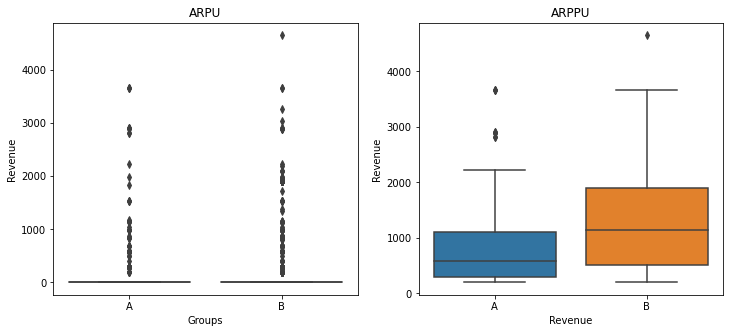

In [16]:
# посмотрим на boxplot наших групп в разрезе метрик
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(y='Revenue', x='Groups', data=res_full_data.rename(columns={'grp': 'Groups', 'rev': 'Revenue'}), ax=ax1)
ax1.set_title('ARPU')
sns.boxplot(y='Revenue', x='Groups', data=res_pay_data.rename(columns={'grp': 'Groups', 'rev': 'Revenue'}), ax=ax2)
ax2.set_title('ARPPU')
plt.xlabel('Revenue')
plt.show()

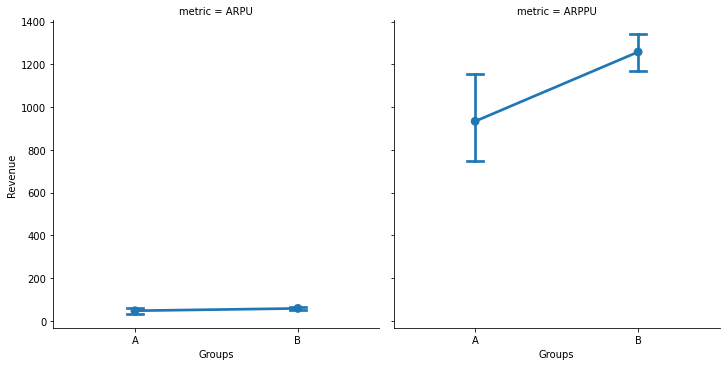

In [17]:
# посмотрим на catplot наших групп в разрезе метрик
sns.catplot(data=res_metric_data.rename(columns={'grp': 'Groups', 'rev': 'Revenue'}), x='Groups', y='Revenue',
            kind='point', capsize=.1, col='metric')
plt.show()

Визуально можно обратить внимание, что метрика `ARPPU` изменилась в положительную сторону. Про метрику `ARPU` визуально трудно определить что произошло, но можно предположить, что при изменении метрики `ARPPU` в положительную сторону, `ARPU` увеличилась также в положительную сторону.

Посчитаем, как изменились наши метрики для тестовой и контрольной групп. Для рассчета метрики `CR` будем использовать формулу:

$$
CR = \frac{{User Pay}}{{User Full}}
$$

, для рассчета метрики `ARPU` будем использовать формулу:

$$
ARPU = \frac{Revenue}{{User Full}}
$$

, для рассчета метрики `ARPPU` будем использовать формулу:

$$
ARPPU = \frac{Revenue}{{User Pay}}
$$

, где ${User Pay}$ - количество платящих пользователей, ${UserFull}$ - общее количество пользователей, $Revenue$ - доход.

In [18]:
# рассчитываем конверсию
cr_a = res_data.loc[(res_data['grp']=='A')&(res_data['rev']>0), 'id'].nunique() \
    / res_data.loc[res_data['grp']=='A', 'id'].nunique()
cr_b = res_data.loc[(res_data['grp']=='B')&(res_data['rev']>0), 'id'].nunique() \
    / res_data.loc[res_data['grp']=='B', 'id'].nunique()

# рассчитываем показатель ARPU
arpu_a = res_full_data.loc[res_full_data['grp']=='A', 'rev'].sum() / res_full_data.loc[res_full_data['grp']=='A', 'id'].nunique()
arpu_b = res_full_data.loc[res_full_data['grp']=='B', 'rev'].sum() / res_full_data.loc[res_full_data['grp']=='B', 'id'].nunique()

# рассчитываем показатель ARPPU
arppu_a = res_pay_data.loc[res_pay_data['grp']=='A', 'rev'].sum() / res_pay_data.loc[res_pay_data['grp']=='A', 'id'].nunique()
arppu_b = res_pay_data.loc[res_pay_data['grp']=='B', 'rev'].sum() / res_pay_data.loc[res_pay_data['grp']=='B', 'id'].nunique()

print('Конверсия группы A: {cr_a:.3%}\nКонверсия группы B: {cr_b:.3%}'.format(cr_a=cr_a, cr_b=cr_b))
print('---') # отсечение вывода
print('Изменение конверсии: {diff__cr:.3%} ({diff_cr:.3%})'.format(diff__cr=cr_b-cr_a, diff_cr=(cr_b-cr_a)/cr_a))
print('\n')
print('ARPU группы A: {arpu_a:.2f}\nARPU группы B: {arpu_b:.2f}'.format(arpu_a=arpu_a, arpu_b=arpu_b))
print('---') # отсечение вывода
print('Изменение ARPU: {diff__:.2f} ({diff_:.3%})'.format(diff__=arpu_b-arpu_a, diff_=(arpu_b-arpu_a)/arpu_a))
print('\n')
print('ARPPU группы A: {arppu_a:.2f}.\nARPPU группы B: {arppu_b:.2f}'.format(arppu_a=arppu_a, arppu_b=arppu_b))
print('---') # отсечение вывода
print('Изменение ARPPU: {diff__:.2f} ({diff_:.3%})'.format(diff__=arppu_b-arppu_a, diff_=(arppu_b-arppu_a)/arppu_a))

Конверсия группы A: 5.072%
Конверсия группы B: 4.616%
---
Изменение конверсии: -0.456% (-8.990%)


ARPU группы A: 47.35
ARPU группы B: 58.06
---
Изменение ARPU: 10.71 (22.623%)


ARPPU группы A: 933.59.
ARPPU группы B: 1257.88
---
Изменение ARPPU: 324.29 (34.736%)


Мы видим, что средний чек на одного пользователя и средний чек на одного платящего пользователя увеличились на `10.71 руб.` и на `324.29 руб.` соответственно, при этом конверсия в активного пользователя снизилась на `0.46%`, что является достаточно существенным снижением. Одной из причин может быть:
* возникновение ошибки в оплате у какой-то группы пользователей (например, в одном из регионов оплата не проходит, например, MasterCard оплата не проходит или СБП);
* изменение механизма оплаты может привести к дополнительным расходам, которые лягут на плечи клиента, в результате чего могут взыматься дополнительные комиссии и пользователи отваливаются из-за этого;

Получив такой результат, нам необходимо проверить являются ли полученные изменения статистически значимыми.

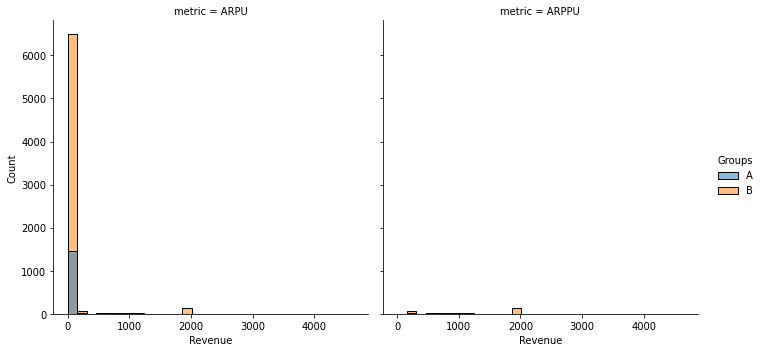

In [19]:
# посмотрим на распределения наших групп в разрезе метрик
sns.displot(x='Revenue', hue='Groups', data=res_metric_data.rename(columns={'grp': 'Groups', 'rev': 'Revenue'}),
            bins=30, col='metric')
plt.show()

По графику наблюдяется явное не нормальное распределение.

**Но зачем нам так необходимо нормальное распределение?**

```md
Нормальное распределение дает нам значительное преимущество. Ведь если наша выборка распределена нормально, то в `95%` случаев она включила бы в себя и среднее всей генеральной совокупности (в соответствии с `ЦПТ`). А значит описывала бы генеральную совокупность с допустимой долей вероятности.
```

**Можно ли попробовать преобразовать наши данные?**

```md
Вообще, данные можно преобразовать, например, прологарифмировать показатель `Revenue` но в данных присутствуют значение `0`, логарифм от которого не определен.

In[]:
np.log(res_metric_data['rev']).head(3)

Out[]:
0    6.897705
1        -inf
2        -inf
Name: rev, dtype: float64
```

**Может тест на нормальность покажет что-то хорошее для нас?**

Стоит попробовать.

При проверке на нормальность рассматривается 2 статистические гипотезы:

```md
1. Н0 - наше распределение не отлично от нормального.
2. Н1 (альтернативная гипотеза) - наше распределение отлично от нормального.
```

In [20]:
# Проверим наши данные на нормальность
print(
    'Метод Шапиро-Вилка (ARPU):',
    pg.normality(data=res_full_data, dv='rev', group='grp'),
    sep='\n'
)

print('\n')

print(
    'Метод Шапиро-Вилка (ARPPU):',
    pg.normality(data=res_pay_data, dv='rev', group='grp'),
    sep='\n'
)

Метод Шапиро-Вилка (ARPU):
          W  pval  normal
A  0.154167   0.0   False
B  0.181245   0.0   False


Метод Шапиро-Вилка (ARPPU):
          W          pval  normal
A  0.735324  1.498682e-10   False
B  0.854724  1.543702e-16   False


In [21]:
print(
    'Комплексный тест на нормальность (ARPU):',
    pg.normality(data=res_full_data, dv='rev', group='grp', method='normaltest'),
    sep='\n'
)

print('\n')

print(
    'Комплексный тест на нормальность (ARPPU):',
    pg.normality(data=res_pay_data, dv='rev', group='grp', method='normaltest'),
    sep='\n'
)

Комплексный тест на нормальность (ARPU):
             W  pval  normal
A  2240.595797   0.0   False
B  7797.399212   0.0   False


Комплексный тест на нормальность (ARPPU):
           W          pval  normal
A  30.378420  2.531687e-07   False
B   6.795663  3.344572e-02   False


Статистические тесты также показывают, вероятность получить распределение близко к нормальному крайне мала, в результате чего нулевая гипотеза отвергается в пользу альтернативной.

Чтобы проверить статистическую значимость наших различий в выборках, можно воспользоваться либо параметрическим тестом `t-критерий Стъюдента`, либо непараметрическим `U-критерием Манна Уитни`. Но для применения `t-критерия` необходимо, чтобы выборочные средние имели нормальное распределение. При маленьких выборках (в нашем случае) это означает требование нормальности исходных данных. А как мы выяснили ранее, что у нас недостаточно оснований считать распределение нормальным.

Можем воспользоваться `U-критерием Манна Уитни`.

В данном случае у нас также будет проверяться 2-е гипотезы:

```md
1. H0 (нулевая гипотеза) - наши группы не имеют значимых различий.
2. H1 (альтернативная гипотеза) - наши группы имеют значимые различия.
```

In [22]:
# ARPU Mann-Whithey
print(
    'U-test Mann Whitney (ARPU):',
    pg.mwu(x=res_full_data.loc[res_full_data['grp']=='B', 'rev'], y=res_full_data.loc[res_full_data['grp']=='A', 'rev']),
    sep='\n'
)

print('\n')

print(
    'U-test Mann Whitney (ARPPU):',
    pg.mwu(x=res_pay_data.loc[res_pay_data['grp']=='B', 'rev'], y=res_pay_data.loc[res_pay_data['grp']=='A', 'rev']),
    sep='\n'
)

U-test Mann Whitney (ARPU):
         U-val alternative     p-val       RBC      CLES
MWU  5210901.0   two-sided  0.509975  0.003939  0.498031


U-test Mann Whitney (ARPPU):
       U-val alternative     p-val       RBC      CLES
MWU  15491.0   two-sided  0.000251 -0.264984  0.632492


Тест Манна Уитни показал, что для метрики `ARPU` мы **НЕ** получили статистически значимое изменение, а для метрики `ARPPU` - получили статистически значимое изменение.

**Почему так получается?**
```md
Все дело в том, что в нашей выборке достаточно большое количество студентов, которые не производили оплату в ходе эксперимента. Поэтому большому количеству показателей присваиваются одинаковые ранги. В результате чего для метрики `ARPU` нельзя говорить о значимых различий.

-- кол-во наблюдений не производивших оплату
In[]: res_metric_data.loc[res_metric_data['rev']==0].groupby(['metric', 'grp'])['id'].nunique()

Out[]: metric  grp
       ARPU    A      1460
               B      6489
       Name: id, dtype: int64
       
-- кол-во всех наблюдений в разрезе метрик и групп
In[]: res_metric_data.groupby(['metric', 'grp'])['id'].nunique()

Out[]: metric  grp
       ARPPU   A        78
               B       314
       ARPU    A      1538
               B      6803
       Name: id, dtype: int64
```

Т.к. большое кол-во пользователей имеют одинаковые значения, то это может негативно сказаться на статистической значимости даннного показателя.

Наиболее эффективный метод проверки в данном случае является `Bootstrapping` [например, ссылка на Википедию](https://en.wikipedia.org/wiki/Bootstrapping_(statistics) "Нажми, у тебя все получится").

Если коротко о главном, то:
1. Из каждой выборки группы A и B мы формируем подвыборку. Причем, делаем это таким образом, что после каждого взятого элемента, мы возвращаем его обратно в выборку.
2. Находим разность статистик наших подвыборок (статистика - это `numpy.mean`, `numpy.median`, `numpy.quantile` и т.д.).
3. Повторяем Шаг 1 и Шаг 2 несколько раз (в нашем примере ниже мы производим `1000 итераций`).
4. Затем смотрим, если в доверительный интервал с определенным уровнем значимости (в нашем примере ниже - это `95%`) распределения из разности наших статистик попадает `0`, то наши результаты получаются статистически не значимыми, т.е. у нас недостаточно оснований говорить о различиях в наших группах.

In [23]:
def get_bootstrap(
    data1, # данные 1-ой выборки
    data2, # данные 2-ой выборки
    boot_it = 1000, # количество подвыборок для оценки
    statistic = np.mean, # статистика
    confidence_level = .95, # уровень значимости
    metric = '' # наименование метрики
):
    boot_data = []
    data1_rev = data1['rev']
    data2_rev = data2['rev']
    boot_len = max([data1.shape[0], data2.shape[0]])
    
    for i in tqdm(range(boot_it)):
        # извлекаем подвыборки из наших выборок
        samples1 = data1_rev.sample(boot_len, replace=True).values
        samples2 = data2_rev.sample(boot_len, replace=True).values
        
        # находим разность между статистиками
        boot_data.append(statistic(samples1)-statistic(samples2))
        
    data_boot_res = pd.Series(boot_data)
    
    # находим левый и правый квантили (границу отсечения)
    conf_level_l = (1-confidence_level)/2
    conf_level_r = 1-(1-confidence_level)/2
    lq, rq = data_boot_res.quantile([conf_level_l, conf_level_r]).values
    
    p_1 = stats.norm.cdf(
        x=0,
        loc=np.mean(boot_data),
        scale=np.std(boot_data)
    )
    
    p_2 = stats.norm.cdf(
        x=0,
        loc=-np.mean(boot_data),
        scale=np.std(boot_data)
    )
    
    p_value = min(p_1, p_2) * 2
    
    # визуализация результатов bootstrap анализа
    _, _, bars = plt.hist(data_boot_res, bins=50)
    for bar in bars:
        if bar.get_x() <= lq or bar.get_x() >= rq:
            bar.set_facecolor('red')
        else:
            bar.set_facecolor('gray')
            bar.set_edgecolor('black')
            
    plt.style.use('ggplot')
    plt.vlines([lq, rq],ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title('Histogram ' + metric)
    plt.show()
    
    print((f'Statistic: {statistic(data_boot_res)}', f'p-value: {p_value}'))
    
    return (data_boot_res, statistic(data_boot_res), p_value)

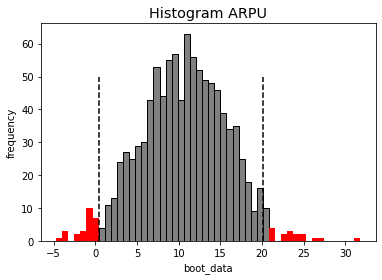

('Statistic: 10.687599659444368', 'p-value: 0.036390551834145066')


In [24]:
data_boot, stat_boot, p_value = get_bootstrap(res_full_data[res_full_data['grp']=='B'], res_full_data[res_full_data['grp']=='A'],
                                              metric='ARPU')

Можно обратить внимание, что в данном случае у нас получилось статистически значимое изменение для `ARPU`

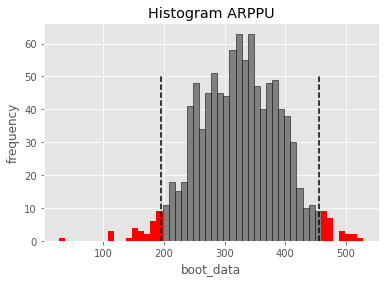

('Statistic: 323.94850486082805', 'p-value: 1.8676561071827823e-06')


In [25]:
data_boot, stat_boot, p_value = get_bootstrap(res_pay_data[res_pay_data['grp']=='B'], res_pay_data[res_pay_data['grp']=='A'],
                                              metric='ARPPU')

А также статистически значимое изменение получилось и для показателя `ARPPU`

Проверим статистически значимо ли изменился наш коэффициент конверсии `CR`. Для этого для начала зададим функцию статистики для рассчета показателя:

In [26]:
def stat_cr(ser): # pd.Series
    return len(ser[ser>0]) / len(ser)

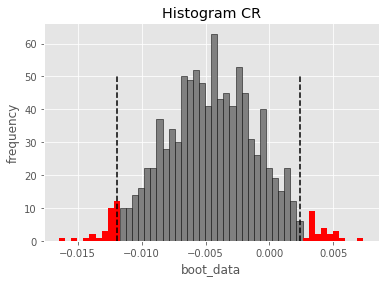

('Statistic: 0.106', 'p-value: 0.21472141303354797')


In [27]:
data_boot, stat_boot, p_value = get_bootstrap(res_data[res_data['grp']=='B'], res_data[res_data['grp']=='A'], statistic=stat_cr,
                                              metric='CR')

А вот изменение показателя `CR` не является статистически значимым.
### Вывод
В результате изменения механизма оплаты мы получили увеличение метрик `ARPU` и `ARPPU`, но снижение метрики `CR`.

**Можем ли мы раскатить новый механизм оплаты на всех пользователей?**
```md
Да, можем.
```

**Почему?**
```md
В результате `Bootstrapping` анализа мы получили статистически значимое изменение наших метрик `ARPU` и `ARPPU`. Т.к. данные метрики увеличились, при этом увеличились статистически значимо это означает, что наш механизм положительно влияет на дальнейший прирост прибыли. Не смотря на то, что показатель `CR` снизился, `Bootstrapping` показал, что это снижение не является статистически значимым. Но все же необходимо более детально проанализировать, что повлияло на снижение данной метрики.
```

#### Задание 3. Дополнительные функции Python
#### 3.1 Задача
1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла `groups_add.csv` (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

In [28]:
def update_data(
    url,
    idx='id',
    grp='grp',
    uniq=True,
    r=3,
    metrics=[True, True, True]
):
    
    """ function update_data
    
    url: pd.DataFrame
        Ссылка на дополнительный массив данных с информацией о принадлежности пользователей к определенной группе.
    idx: str, default 'id'
        Наименование столбца, в котором содержатся идентификаторы пользователя.
    grp: str, default 'grp'
        Наименование столбца, в котором содержится информация о принадлежности к группе.
    uniq: bool, default True
        Проверка на уникальность,
            * если True, то проверяет имеет ли поле idx уникальные значения;
            * если False, то соединяет данные без проверки.
    r: int, default 3
        Количество знаков после запятой для дробных чисел.
    metrics: bool, list bool or list str, default [True, True, True]
        Метрики, которые необходимо рассчитать:
            * если True, то считает все метрики;
            * если список [True, True, True], то учитывается порядок метрик, ['ARPU', 'ARPPU', 'CR'];
            * если список ['CR', 'ARPU'], то рассчитываются только метрики, указанные в списке, в установленном списком порядке.
    
    Returns: pd.DataFrame
        Датафрейм с метриками, разделенными по группам.
    """
    # список всех компонентов, которые будут возвращены функцией
    dict_return = {}
    
    # список всевозможных метрик
    metric_names = ['ARPU', 'ARPPU', 'CR']
    
    # считываем наши новые данные
    ndata = pd.read_csv(base_url+url)
    # переименовываем столбцы для дальнейшей конкатенации
    ndata = ndata.rename(columns={idx: 'id', grp: 'grp'})[['id', 'grp']]
    
    # проверяем на наличие повторений
    if uniq: dupl = groups_data.merge(ndata, how='inner', on='id')['id']
    else: dupl = None
    
    # конкатенируем данные с основным массивом
    return_data = pd.concat([groups_data, ndata]).reset_index(drop=True)
    
    # добавляем основные данные для рассчета метрик
    return_data = return_data.merge(active_studs_data.rename(columns={'student_id': 'id'}), on='id')
    return_data = return_data.merge(checks_data.rename(columns={'student_id': 'id'}), how='left', on='id') \
        .fillna({'rev': 0})
    
    # функции для расчета метрик
    def f_arpu(): # calc ARPU
        dict_arpu = {}
        for group in return_data['grp'].unique():
            dict_arpu[group] = round(sum(return_data.loc[return_data['grp']==group, 'rev']) \
                                         / return_data.loc[return_data['grp']==group].shape[0], r)
            
        return dict_arpu
    
    def f_arppu(): # calc ARPPU
        dict_arppu = {}
        for group in return_data['grp'].unique():
            dict_arppu[group] = round(sum(return_data.loc[(return_data['grp']==group)&(return_data['rev']>0), 'rev']) \
                                          / return_data.loc[(return_data['grp']==group)&(return_data['rev']>0)].shape[0], r)
            
        return dict_arppu
    
    def f_cr(): # calc CR
        dict_cr = {}
        for group in return_data['grp'].unique():
            dict_cr[group] = round(return_data.loc[(return_data['grp']==group)&(return_data['rev']>0)].shape[0] \
                                   / return_data.loc[(return_data['grp']==group)].shape[0], r+2)
            
        return dict_cr
    
    # рассчитываем основные метрики
    if isinstance(metrics, bool):
        if metrics:
            dict_return['ARPU'] = f_arpu()
            dict_return['ARPPU'] = f_arppu()
            dict_return['CR'] = f_cr()
        else: pass
    elif isinstance(metrics, list):
        for metric, metric_name in zip(metrics, metric_names):
            if isinstance(metric, bool):
                if metric_name == 'ARPU' and metric: dict_return['ARPU'] = f_arpu()
                elif metric_name == 'ARPPU' and metric: dict_return['ARPPU'] = f_arppu()
                elif metric_name == 'CR' and metric: dict_return['CR'] = f_cr()
                else: pass
            elif isinstance(metric, str):
                if metric == 'ARPU': dict_return['ARPU'] = f_arpu()
                elif metric == 'ARPPU': dict_return['ARPPU'] = f_arppu()
                elif metric == 'CR': dict_return['CR'] = f_cr()
                else: pass
            else: pass
    else: pass
    
    return (pd.DataFrame(dict_return).reset_index().rename(columns={'index': 'Groups'}), dupl)

In [29]:
df1, dupl = update_data(groups_add_data_url, metrics=True)
print(df1)

  Groups    ARPU     ARPPU       CR
0      A  47.347   933.590  0.05072
1      B  58.059  1257.879  0.04616


In [30]:
print(dupl)

Series([], Name: id, dtype: int64)


In [31]:
df2, dupl = update_data(groups_add_data_url, uniq=False, metrics=[True, False, True])
print(df2)

  Groups    ARPU       CR
0      A  47.347  0.05072
1      B  58.059  0.04616


In [32]:
df3, dupl = update_data(groups_add_data_url, uniq=False, r=6, metrics=['ARPU', 'CR'])
print(df3)

  Groups       ARPU        CR
0      A  47.347204  0.050715
1      B  58.058798  0.046156


In [33]:
print(dupl)

None


2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [34]:
def charts(data):
    metrics = data.columns[1:]
    
    fig, ax = plt.subplots(1, len(metrics), figsize=(16, 4))
    for i in range(len(metrics)):
        ax[i].bar(x=data['Groups'], height=data.iloc[:, i+1], width=.75,
                  color=['#14213d', '#fca311'], alpha=.8)
        ax[i].set_title(data.iloc[:, i+1].name)
        ax[i].set_xlabel('Groups')
        ax[i].set_ylabel('Value')
        
    plt.show()

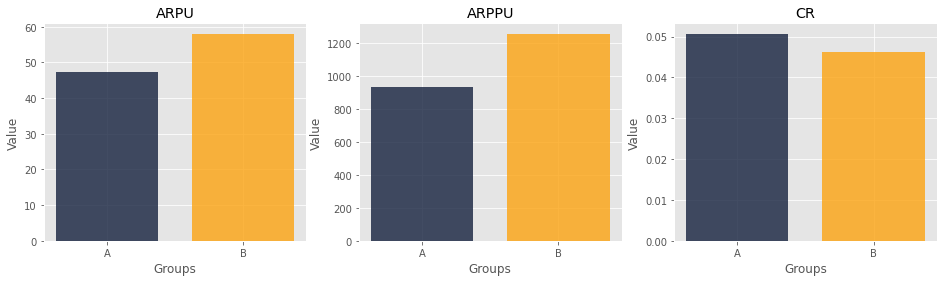

In [35]:
charts(df1)

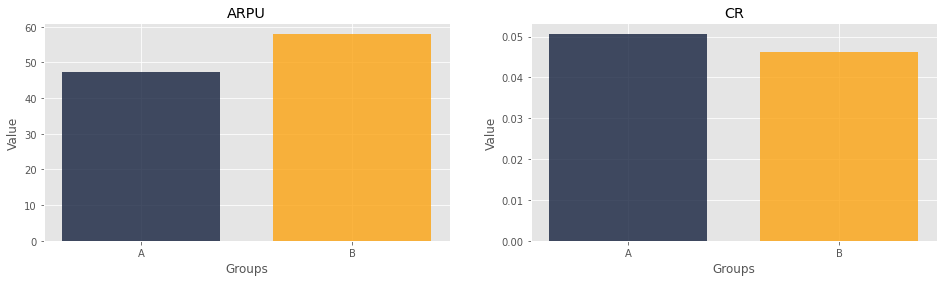

In [36]:
charts(df2)

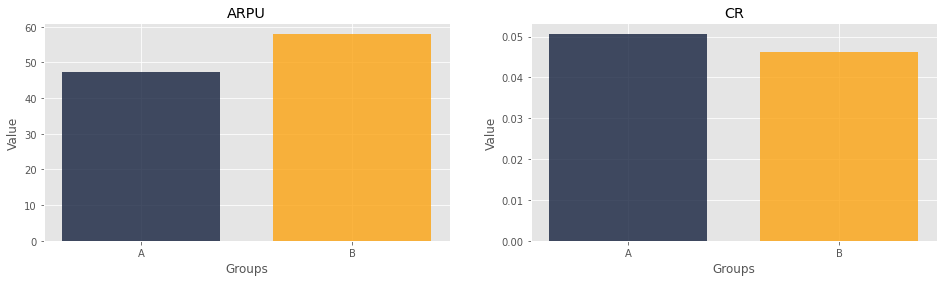

In [37]:
charts(df3)